In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend
from keras import layers, Input, Model, ops

import seaborn as sns
import pickle

In [ ]:
## Loading t

We take the pickle file containing the images (for now, from the A1 corner) and the csv file containing the redshifts.

In [2]:
# Change these path names to correspond with your directory
# DATASET_PATH ="/YOUR_PATH/lfw-deepfunneled/"
# ATTRIBUTES_PATH = "/YOUR_PATH/lfw_attributes.txt"

DATA_PATH = "A1_compiled_cutouts_3arcsec_30mas.pkl"

In [3]:
# Load data
# rows: ID, image info, redshift
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f) 

/var/folders/_7/2zx358892jg3bmslfmn_820w0000gn/T/ipykernel_89852/150499598.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [4]:
# IDs
ids = data[0]

# images
images = np.stack(data[1]).astype("float32")
print(np.min(images))
images = np.log10(images - np.min(images)+0.01)
print(np.max(images))
images = images / np.max(images)  # normalize

-0.95650524
2.72259


The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [5]:
attrs = pd.read_csv("cosmos_cut.csv", sep=",")

df_images = pd.DataFrame({'id': ids})
merged = pd.merge(df_images, attrs, on="id", how="inner") # only when IDs match

images = images[merged.index]
redshifts = merged["z"].to_numpy(dtype="float32")
redshifts = redshifts / np.max(redshifts)

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [6]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [7]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    noise = backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * noise

In [8]:
# two branch encoder for images and redshifts

# image branch
image_input = layers.Input(shape=(100, 100, 4))

x_encoder = layers.Conv2D(64, (5,5), activation='relu', padding='same')(image_input)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x_encoder)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x_encoder)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Flatten()(x_encoder)

# redshift branch (scalar)
redshift_input = layers.Input(shape=(1,), name='redshift_input')
redshift_dense = layers.Dense(16, activation='relu')(redshift_input)  # projection

# merge image and redshift
merged = layers.Concatenate()([x_encoder, redshift_dense])

distribution_mean = layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(merged)
distribution_variance = layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(merged)

# Sampling function
latent_encoding = layers.Lambda(sample_latent_features, 
                                output_shape=(LATENT_SPACE_SIZE,))([distribution_mean, distribution_variance])

# Encoder model
encoder_model = Model(inputs=[image_input, redshift_input], outputs=latent_encoding)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │      6,464 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     18,464 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         32 │ redshift_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4624)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 100)       │    462,500 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 100)       │    462,500 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ variational_mean… │
│                     │                   │            │ variational_log_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 986,888 (3.76 MB)

 Trainable params: 986,888 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [9]:
# inputs
decoder_inputs = Input(shape=(LATENT_SPACE_SIZE,), name='latent_input')

# Fully connected to match encoder's flattened feature map
x_decoder = layers.Dense(12*12*32, activation='relu')(decoder_inputs)
x_decoder = layers.Reshape((12,12,32))(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 12 -> 24
x_decoder = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 24 -> 48
x_decoder = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 48 -> 96
x_decoder = layers.Conv2DTranspose(64, (5,5), activation='relu', padding='same')(x_decoder)

# pad to correct for integer division in encoder
x_decoder = layers.ZeroPadding2D(((2,2), (2,2)))(x_decoder)
decoded_image = layers.Conv2D(4, (5,5), activation='sigmoid', padding='same')(x_decoder)

# reconstruct redshift
decoded_redshift = layers.Dense(1, name='reconstructed_redshift')(decoder_inputs)

decoder_model = Model(decoder_inputs, [decoded_image, decoded_redshift])
decoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4608)      │    465,408 │ latent_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 12, 12,    │          0 │ dense_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 24, 24,    │          0 │ reshape[0][0]     │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 24, 24,    │      9,248 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 48, 48,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 48, 48,    │     18,496 │ up_sampling2d_1[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 96, 96,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 96, 96,    │    102,464 │ up_sampling2d_2[… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 100, 100,  │          0 │ conv2d_transpose… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 100,  │      6,404 │ zero_padding2d[0… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstructed_reds… │ (None, 1)         │        101 │ latent_input[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 602,121 (2.30 MB)

 Trainable params: 602,121 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
encoded = encoder_model([image_input, redshift_input])
decoded_image, decoded_redshift = decoder_model(encoded)
autoencoder = tf.keras.models.Model([image_input, redshift_input],
                                    [decoded_image, decoded_redshift])

In [11]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):
    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = (LATENT_SPACE_SIZE + distribution_variance - ops.square(distribution_mean) - ops.exp(distribution_variance))
        kl_loss_batch = ops.sum(kl_loss) / batch_size
        return kl_loss_batch * (-0.5)

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = ops.square(y_true - y_pred)
        reconstruction_loss_batch = ops.sum(reconstruction_loss) / batch_size
        return reconstruction_loss_batch * factor

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [12]:
X_train, X_val, z_train, z_val = train_test_split(images, redshifts, test_size=0.2, random_state=365)



In [13]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 100)       │    986,888 │ input_layer[0][0… │
│ (Functional)        │                   │            │ redshift_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 100, 100, │    602,121 │ functional[0][0]  │
│ (Functional)        │ 4), (None, 1)]    │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,589,009 (6.06 MB)

 Trainable params: 1,589,009 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
LATENT_DIM = 100

# ---- Inputs
img_in = layers.Input(shape=(100, 100, 4), name="image")
z_in   = layers.Input(shape=(1,),          name="redshift")

# ---- Image branch
x = layers.Conv2D(64, 5, padding="same", activation="relu")(img_in)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

# ---- Concatenate image features + redshift
hg = layers.Dense(512, activation="relu")(z_in)
h = layers.Concatenate()([x, hg])
#h = layers.Dense(512, activation="relu")(h)

# ---- Latent parameters
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(h)
z_logv = layers.Dense(LATENT_DIM, name="z_logvar")(h)

# ---- Sampling layer that ALSO adds KL via add_loss
class Sampling(layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def build(self, input_shape):
        self.rng = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        mean, logvar = inputs
        eps = keras.random.normal(shape=ops.shape(mean),
                                  dtype=mean.dtype,
                                  seed=self.rng)
        z = mean + ops.exp(0.5 * logvar) * eps

        # KL per sample
        kl_per_sample = -0.5 * ops.sum(
            1 + logvar - ops.square(mean) - ops.exp(logvar), axis=-1
        )
        # Apply weighting factor (β-VAE trick)
        self.add_loss(self.beta * ops.mean(kl_per_sample))
        return z

z_latent = Sampling(beta=0.5, name="z")([z_mean, z_logv])

# Encoder after 3 pools is 12x12 (since 100 -> 50 -> 25 -> 12)
# ---- Decoder (hybrid upsampling + convolution)
d = layers.Dense(12 * 12 * 64, activation="relu")(z_latent)
d = layers.Reshape((12, 12, 64))(d)  # start from 12x12

# 12 -> 24
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 24 -> 48
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 48 -> 96
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(32, 3, padding="same", activation="relu")(d)

# Final adjustment: 96 -> 100
d = layers.Resizing(100, 100, interpolation="bilinear")(d)

# Output reconstruction (linear activation since it's regression)
x_recon = layers.Conv2D(4, 3, padding="same", activation="linear", name="image_recon")(d)

# ---- Optional small head to reconstruct the scalar redshift as an auxiliary target
z_hat = layers.Dense(32, activation="relu")(z_latent)
z_hat = layers.Dense(1,  activation="linear", name="z_recon")(z_hat)

autoencoder = keras.Model(inputs=[img_in, z_in], outputs=[x_recon, z_hat], name="vae")

# Only reconstruction losses go in compile. The KL is already attached via add_loss.
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={"image_recon": "mse", "z_recon": "mse"},
    loss_weights={"image_recon": 1000.0, "z_recon": 1.0},)


In [24]:
autoencoder.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 100, 100,  │      6,464 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 50, 50,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 50, 50,    │     36,928 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 25, 25,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 25, 25,    │     18,464 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │      1,024 │ redshift[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 5120)      │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_logvar[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 9216)      │    930,816 │ z[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 12, 12,    │          0 │ dense_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 24, 24,    │          0 │ reshape_3[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 24, 24,    │     36,928 │ up_sampling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,114,637 (8.07 MB)

 Trainable params: 2,114,637 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)


history = autoencoder.fit(
    [X_train, z_train],               # inputs: images + redshift
    [X_train, z_train],               # targets: reconstruct both
    epochs=5,
    batch_size=64,
    validation_data=([X_val, z_val], [X_val, z_val]))

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - image_recon_loss: 8.7273e-05 - loss: 0.5770 - z_recon_loss: 0.4632 - val_image_recon_loss: 2.7427e-05 - val_loss: 0.2773 - val_z_recon_loss: 0.2473
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - image_recon_loss: 2.2316e-05 - loss: 0.2183 - z_recon_loss: 0.1936 - val_image_recon_loss: 2.6107e-05 - val_loss: 0.1834 - val_z_recon_loss: 0.1611
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - image_recon_loss: 2.1532e-05 - loss: 0.1629 - z_recon_loss: 0.1396 - val_image_recon_loss: 2.5656e-05 - val_loss: 0.1602 - val_z_recon_loss: 0.1378
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - image_recon_loss: 2.1298e-05 - loss: 0.1422 - z_recon_loss: 0.1196 - val_image_recon_loss: 2.5547e-05 - val_loss: 0.1221 - val_z_recon_loss: 0.0947
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - image_recon_loss: 2.1158e-05 - loss: 0.1174 - z_recon_loss: 0.0955 - val_image_recon_loss: 2.5527e-05 - val_loss: 0.1057 - val_z_recon_loss: 0.0829


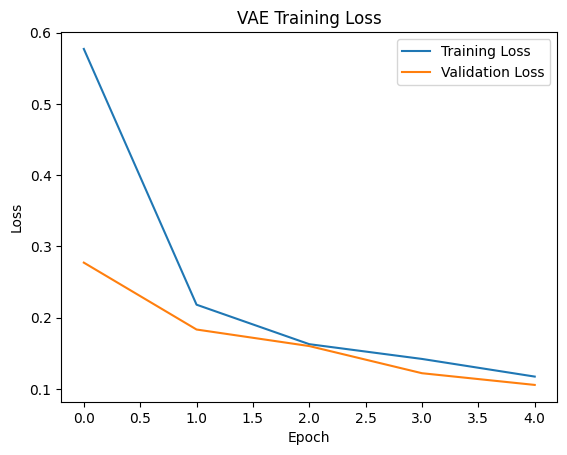

In [26]:
# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def _asinh_stretch(x, scale=None):
    """
    Asinh stretch commonly used for astro images.
    If scale is None, use a robust estimate based on the 90th percentile of |x|.
    """
    x = np.asarray(x)
    if scale is None:
        p = np.nanpercentile(np.abs(x), 90)
        scale = p if p > 0 else np.nanmax(np.abs(x)) + 1e-8
    return np.arcsinh(x / (scale + 1e-12))

def _auto_vmin_vmax(x, pct=(1, 99)):
    """Robust display limits from percentiles."""
    lo, hi = np.nanpercentile(x, pct[0]), np.nanpercentile(x, pct[1])
    if hi <= lo:  # fallback
        m, s = np.nanmean(x), np.nanstd(x)
        lo, hi = m - 2*s, m + 2*s
    return float(lo), float(hi)

def show_input_vs_output(
    model,
    X,
    z,
    idx=0,
    channel_names=None,
    stretch="asinh",      # 'asinh' or 'linear'
    percentiles=(1, 99),  # for linear scaling
    figsize=(12, 6),
    cmap="gray",
    show_residuals=True,
    print_redshift=True,
):
    """
    Visualize original vs reconstructed image for a single (image, redshift) pair.

    Parameters
    ----------
    model : keras.Model
        Your trained VAE model with outputs [image_recon, z_recon] or [image_recon].
    X : np.ndarray
        Image array of shape (N, H, W, C). (C should be 4 for your use case.)
    z : np.ndarray
        Redshift array of shape (N, 1) or (N,).
    idx : int
        Index of the sample to visualize.
    channel_names : list[str] or None
        Optional names for channels (e.g., ["F115W","F150W","F277W","F444W"]).
    stretch : {'asinh', 'linear'}
        Display stretch for visualization.
    percentiles : tuple(int,int)
        For 'linear' stretch, the (low, high) percentiles to set vmin/vmax.
    figsize : tuple
        Figure size.
    cmap : str
        Matplotlib colormap.
    show_residuals : bool
        If True, shows a third row with (recon - input).
    print_redshift : bool
        If True, prints the input redshift and predicted redshift (if available).

    Returns
    -------
    dict with keys:
        'x_true', 'x_recon', 'z_true', 'z_pred', 'residual'
    """

    # Prepare the specific sample
    x_true = X[idx]
    z_true = z[idx]
    if z_true.ndim == 0:        # scalar -> (1,)
        z_true = np.array([z_true], dtype=np.float32)
    if z_true.ndim == 1:        # (1,) -> (1,1) when batching
        z_true_b = z_true.reshape(1, 1)
    else:
        z_true_b = z_true.reshape(1, *z_true.shape)

    x_true_b = x_true[np.newaxis, ...]  # (1,H,W,C)

    # Forward pass
    pred = model.predict([x_true_b, z_true_b], verbose=0)
    if isinstance(pred, (list, tuple)):
        x_recon_b = pred[0]
        z_pred_b = pred[1] if len(pred) > 1 else None
    else:
        x_recon_b = pred
        z_pred_b = None

    x_recon = np.squeeze(x_recon_b, axis=0)  # (H,W,C)
    residual = x_recon - x_true

    # Print redshifts if desired
    if print_redshift:
        try:
            zt_scalar = float(z_true.ravel()[0])
        except Exception:
            zt_scalar = np.nan
        if z_pred_b is not None:
            zp_scalar = float(np.squeeze(z_pred_b))
            print(f"z_true = {zt_scalar:.5f} | z_pred = {zp_scalar:.5f}")
        else:
            print(f"z_true = {zt_scalar:.5f} | (model has no z_pred head)")

    H, W, C = x_true.shape
    cols = C
    rows = 3 if show_residuals else 2

    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    if cols == 1:
        axes = np.expand_dims(axes, 1)

    def format_title(base, c):
        if channel_names and c < len(channel_names):
            return f"{base} – {channel_names[c]}"
        return f"{base} – ch{c}"

    for c in range(C):
        # Choose scaling for each panel
        if stretch == "asinh":
            a_true = _asinh_stretch(x_true[..., c])
            a_reco = _asinh_stretch(x_recon[..., c])
            vmin_t, vmax_t = _auto_vmin_vmax(a_true)
            vmin_r, vmax_r = _auto_vmin_vmax(a_reco)
            # Keep separate vmin/vmax for truth vs recon to show structure clearly
            axes[0, c].imshow(a_true, cmap=cmap, vmin=vmin_t, vmax=vmax_t)
            axes[1, c].imshow(a_reco, cmap=cmap, vmin=vmin_r, vmax=vmax_r)
        else:  # linear
            vmin, vmax = _auto_vmin_vmax(x_true[..., c], percentiles)
            axes[0, c].imshow(x_true[..., c], cmap=cmap, vmin=vmin, vmax=vmax)
            axes[1, c].imshow(x_recon[..., c], cmap=cmap, vmin=vmin, vmax=vmax)

        axes[0, c].set_title(format_title("Input", c))
        axes[1, c].set_title(format_title("Reconstruction", c))
        axes[0, c].axis("off")
        axes[1, c].axis("off")

        if show_residuals:
            # Residuals in linear scale centered at 0 with symmetric range
            res = residual[..., c]
            m = np.nanmax(np.abs(res)) + 1e-12
            axes[2, c].imshow(res, cmap=cmap, vmin=-m, vmax=m)
            axes[2, c].set_title(format_title("Residual (recon - input)", c))
            axes[2, c].axis("off")

    plt.show()

    return {
        "x_true": x_true,
        "x_recon": x_recon,
        "z_true": z_true,
        "z_pred": None if z_pred_b is None else float(np.squeeze(z_pred_b)),
        "residual": residual,
    }


z_true = 0.39020 | z_pred = -0.06880


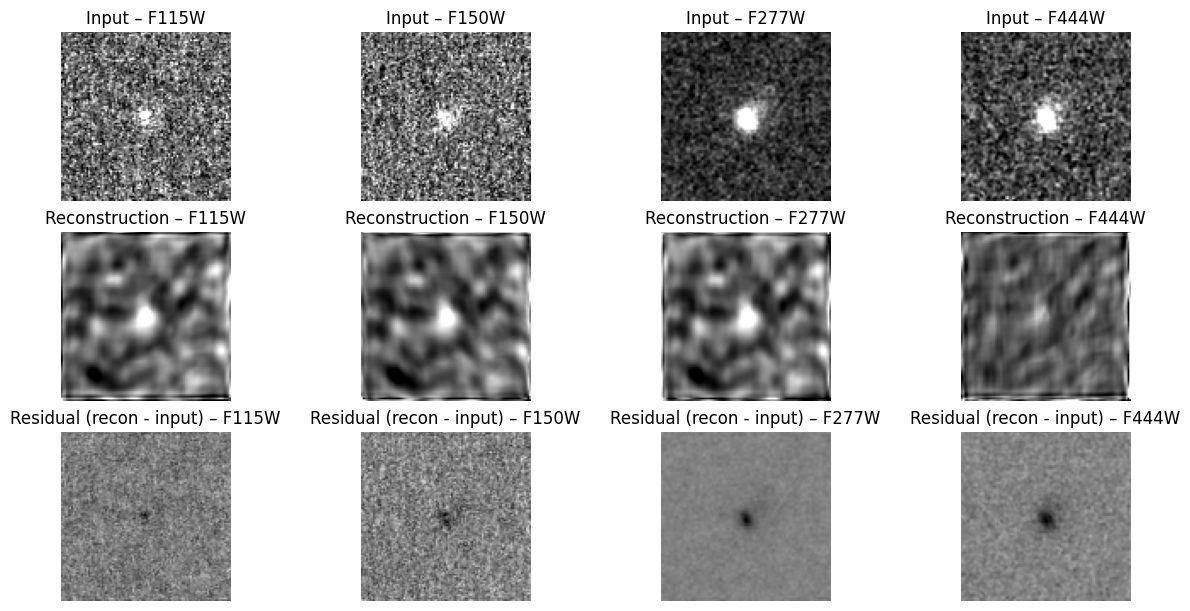

In [28]:
# Example channel labels for your 4-band data:
chan_names = ["F115W", "F150W", "F277W", "F444W"]

# Visualize sample #17 (change idx as you like)
_ = show_input_vs_output(
    autoencoder,
    X_train,
    z_train,
    idx=32,
    channel_names=chan_names,
    stretch="asinh",      # or "linear"
    show_residuals=True,
    cmap="gray",
)


### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [23]:
def LatentSpace_pairplot(encoder_model, data1, label1, data2, label2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    z = np.concatenate((z1, z2))

    # 10 latent dims
    n_dims = 10
    df = pd.DataFrame(z[:, :n_dims], columns=[f"z{i+1}" for i in range(n_dims)])

    sns.pairplot(df, hue='label', plot_kws={'alpha':0.5, 's':20})
    plt.show()

In [ ]:
LatentSpace_pairplot(encoder_model, data1, label1, data2, label2)

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

In [28]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

/Users/mc/opt/anaconda3/envs/STATS315B/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


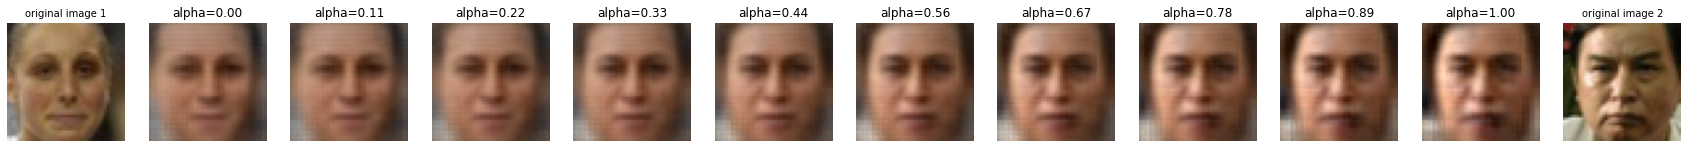

In [29]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)


### 1.5 Attribute shift (10 points)

In [33]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [34]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    delta = np.mean(z1, axis=0) - np.mean(z2, axis=0)
    pic_output = decoder_model.predict(z2 + delta)
    return pic_output